In [1]:
# 导入库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout

c:\Users\13801\anaconda3\envs\Pytorch\lib\site-packages\scipy\__init__.py:173: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# 加载数据集并预览
df=pd.read_csv('./yellow_tripdata_2014-04.csv')
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,CMT,2014-04-08 08:59:39,2014-04-08 09:28:57,1,2.5,-73.958848,40.763585,1,N,-73.986284,40.752034,CRD,18.0,0.0,0.5,3.7,0.0,22.2
1,CMT,2014-04-08 14:59:22,2014-04-08 15:04:52,1,0.9,0.000000,0.000000,1,N,0.000000,0.000000,CRD,6.0,0.0,0.5,1.3,0.0,7.8
2,CMT,2014-04-08 08:45:28,2014-04-08 08:50:41,2,0.6,-73.992233,40.729136,1,N,-73.991387,40.735186,CRD,5.5,0.0,0.5,1.2,0.0,7.2
3,CMT,2014-04-08 08:00:20,2014-04-08 08:11:31,2,0.5,-73.973726,40.750095,1,N,-73.976889,40.755623,CRD,8.0,0.0,0.5,1.7,0.0,10.2
4,CMT,2014-04-08 08:38:36,2014-04-08 08:44:37,1,0.4,-73.973502,40.755479,1,Y,-73.979198,40.758619,CRD,5.5,0.0,0.5,1.2,0.0,7.2


In [3]:
# 数据预处理
# 修改列名字，去除空格
col_name=[]
for col in df.columns:
    col_name.append(col.replace(' ',''))
df.columns=col_name
df.shape

(14618759, 18)

In [4]:
# 先去空值、重复值
df.dropna()
df.drop_duplicates(inplace=True)
df.shape

(14618722, 18)

In [5]:
# 根据乘客数量清洗
df['passenger_count'].value_counts()

1    10324326
2     2003862
5      833159
3      607120
6      551197
4      298913
0         128
7           8
8           5
9           4
Name: passenger_count, dtype: int64

In [6]:
# 出租车乘客不能超过4个，更不能为0个
df=df.loc[df['passenger_count']<=4,:]
df=df[df['passenger_count']!=0]
print(df['passenger_count'].value_counts())
print(df.shape)

1    10324326
2     2003862
3      607120
4      298913
Name: passenger_count, dtype: int64
(13234221, 18)


In [7]:
# 1英里约为1.6公里，故筛选大于1英里的订单为有效订单
df=df.loc[df['trip_distance']>1,:]
print(df['trip_distance'].value_counts())
print(df.shape)

1.10     315114
1.20     302168
1.30     286130
1.40     272233
1.50     256919
          ...  
92.40         1
65.70         1
38.69         1
44.60         1
45.75         1
Name: trip_distance, Length: 4193, dtype: int64
(9967067, 18)


In [8]:
# 去除纽约市范围以外的数据
# 纽约市的经纬度范围，数据参考[参考文献[1]]
nyc_longi_lim = [-74.15, -73.7004]
nyc_lati_lim = [40.5774, 40.9176]

df=df[(df['pickup_longitude']>nyc_longi_lim[0])&(df['pickup_longitude']<nyc_longi_lim[1])]
df=df[(df['pickup_latitude']>nyc_lati_lim[0])&(df['pickup_latitude']<nyc_lati_lim[1])]

df=df[(df['dropoff_longitude']>nyc_longi_lim[0])&(df['dropoff_longitude']<nyc_longi_lim[1])]
df=df[(df['dropoff_latitude']>nyc_lati_lim[0])&(df['dropoff_latitude']<nyc_lati_lim[1])]

print(df.shape)

(9735471, 18)


In [9]:
# 没有无效的订单
print(df['payment_type'].value_counts())

CRD    5857532
CSH    3806672
UNK      47928
NOC      17209
DIS       6130
Name: payment_type, dtype: int64


In [10]:
# 去除不相关的字段
df=df.drop(['vendor_id','rate_code','store_and_fwd_flag',
            'payment_type','fare_amount','surcharge',
            'mta_tax','tip_amount','tolls_amount'],axis=1)
print(df.shape)

(9735471, 9)


In [11]:
# 处理时间特征
df['pickup_totime']=pd.to_datetime(df['pickup_datetime'])

# 将日特征转换为星期几
pick_wk_list=[]
for i in df['pickup_totime']:
    pick_wk_list.append(i.weekday())
df['pickup_weekday']=pick_wk_list

df['dropoff_totime']=pd.to_datetime(df['dropoff_datetime'])
drop_wk_list=[]
for i in df['dropoff_totime']:
    drop_wk_list.append(i.weekday())
df['dropoff_weekday']=drop_wk_list

# 提取小时特征
df['pickup_hour'] = df['pickup_totime'].dt.hour
df['dropoff_hour'] = df['dropoff_totime'].dt.hour

# 丢掉多余特征
df = df.drop(['pickup_datetime','pickup_totime',
              'dropoff_datetime','dropoff_totime'], axis=1)

print(df.head())

    passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                 1            2.5        -73.958848        40.763585   
8                 1            2.9        -74.004322        40.725582   
13                1            1.5        -73.988110        40.745945   
16                1            3.8        -73.987217        40.769016   
17                1            1.4        -74.000734        40.727246   

    dropoff_longitude  dropoff_latitude  total_amount  pickup_weekday  \
0          -73.986284         40.752034         22.20               1   
8          -73.976799         40.758221         17.50               1   
13         -73.975563         40.762515         16.80               1   
16         -74.001984         40.719286         18.12               1   
17         -73.986297         40.737786          8.50               1   

    dropoff_weekday  pickup_hour  dropoff_hour  
0                 1            8             9  
8                 1     

In [12]:
# 处理total_amount里面的异常值
df['total_amount'].describe()

count    9.735471e+06
mean     1.730328e+01
std      1.195978e+01
min      3.000000e+00
25%      1.010000e+01
50%      1.350000e+01
75%      1.920000e+01
max      5.090000e+02
Name: total_amount, dtype: float64

In [13]:
stat=df['total_amount'].describe(percentiles=[0.75,0.8,0.85,0.9,0.95,0.99])
print('0.75:',stat['75%'])
print('0.8:',stat['80%'])
print('0.85:',stat['85%'])
print('0.9:',stat['90%'])
print('0.95:',stat['95%'])
print('0.99:',stat['99%'])

0.75: 19.2
0.8: 21.5
0.85: 24.88
0.9: 31.1
0.95: 43.75
0.99: 67.83


In [14]:
max_percentile_ta=df['total_amount'].quantile(0.85)
max_percentile_ta

24.88

In [15]:
df=df[df['total_amount']<max_percentile_ta]
df.shape

(8272934, 11)

In [16]:
df['total_amount'].describe()

count    8.272934e+06
mean     1.317355e+01
std      4.370181e+00
min      3.000000e+00
25%      9.600000e+00
50%      1.238000e+01
75%      1.600000e+01
max      2.487000e+01
Name: total_amount, dtype: float64

In [17]:
df.to_csv('cleaned_data.csv')

In [18]:
# 根据不同区域的经纬度范围，将纽约市划分为若干个区域，并为每个区域分配一个编号
# 根据经纬度计算行程距离（单位为公里）
def haversine_distance(lat1, lon1, lat2, lon2):
  # 将角度转换为弧度
  lat1 = np.radians(lat1)
  lon1 = np.radians(lon1)
  lat2 = np.radians(lat2)
  lon2 = np.radians(lon2)

  # 计算两点之间的球面距离（km）
  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
  c = 2 * np.arcsin(np.sqrt(a))
  r = 6371 # 地球半径（km）
  return c * r

df['trip_distance_km'] = haversine_distance(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])

In [19]:
df.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,pickup_weekday,dropoff_weekday,pickup_hour,dropoff_hour,trip_distance_km
0,1,2.5,-73.958848,40.763585,-73.986284,40.752034,22.20,1,1,8,9,2.643826
8,1,2.9,-74.004322,40.725582,-73.976799,40.758221,17.50,1,1,16,16,4.306779
13,1,1.5,-73.988110,40.745945,-73.975563,40.762515,16.80,1,1,11,11,2.124090
16,1,3.8,-73.987217,40.769016,-74.001984,40.719286,18.12,1,1,7,8,5.667935
17,1,1.4,-74.000734,40.727246,-73.986297,40.737786,8.50,1,1,22,22,1.689181


In [20]:
# 根据不同区域的经纬度范围，将纽约市划分为若干个区域，并为每个区域分配一个编号
def assign_zone(lat, lon):
  # 纽约市中心区域（编号为0）
  if (40.7 <= lat <= 40.8) and (-74.0 >= lon >= -74.1):
    return 0
  # 纽约市东北区域（编号为1）
  elif (40.8 <= lat <= 40.9) and (-73.9 >= lon >= -74.0):
    return 1
  # 纽约市西南区域（编号为2）
  elif (40.6 <= lat <= 40.7) and (-74.1 >= lon >= -74.2):
    return 2
  # 纽约市其他区域（编号为3）
  else:
    return 3
  
  # 将上车地点和下车地点都划分到相应的区域，并转换为分类变量
df['pickup_zone'] = df.apply(lambda x: assign_zone(x['pickup_latitude'], x['pickup_longitude']), axis=1).astype('category')
df['dropoff_zone'] = df.apply(lambda x: assign_zone(x['dropoff_latitude'], x['dropoff_longitude']), axis=1).astype('category')

In [21]:
df.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,pickup_weekday,dropoff_weekday,pickup_hour,dropoff_hour,trip_distance_km,pickup_zone,dropoff_zone
0,1,2.5,-73.958848,40.763585,-73.986284,40.752034,22.20,1,1,8,9,2.643826,3,3
8,1,2.9,-74.004322,40.725582,-73.976799,40.758221,17.50,1,1,16,16,4.306779,0,3
13,1,1.5,-73.988110,40.745945,-73.975563,40.762515,16.80,1,1,11,11,2.124090,3,3
16,1,3.8,-73.987217,40.769016,-74.001984,40.719286,18.12,1,1,7,8,5.667935,3,0
17,1,1.4,-74.000734,40.727246,-73.986297,40.737786,8.50,1,1,22,22,1.689181,0,3


In [22]:
# 删除一些不再需要的列，如原始时间戳和经纬度等
df.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1, inplace=True)

In [23]:
df=df.groupby(['pickup_weekday','dropoff_weekday','pickup_hour',
                  'trip_distance_km','pickup_zone','dropoff_zone'],observed=True).size().reset_index(name='demand')


In [24]:
print(df.head())
df.to_csv('feature_data.csv')

   pickup_weekday  dropoff_weekday  pickup_hour  trip_distance_km pickup_zone  \
0               0                0            0          0.000000           3   
1               0                0            0          0.000000           0   
2               0                0            0          0.000000           1   
3               0                0            0          0.000169           3   
4               0                0            0          0.000611           3   

  dropoff_zone  demand  
0            3     129  
1            0      18  
2            1       9  
3            3       1  
4            3       1  


In [25]:
# 将数据集划分为训练集和测试集
X = df.drop(['demand'], axis=1) # 特征矩阵
y = df['demand'] # 目标向量
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42) # 划分训练集和测试集

print(X_train,y_train)

         pickup_weekday  dropoff_weekday  pickup_hour  trip_distance_km  \
1737099               1                1           17          2.059338   
2059624               1                1           21          1.591580   
5551835               4                4           19          2.173248   
7342207               6                6            2          4.545805   
4531019               3                3           21          1.818628   
...                 ...              ...          ...               ...   
6550634               5                5           15          1.834669   
7705870               6                6           13          2.242883   
6423388               5                5           13          1.399311   
6962611               5                5           21          3.016355   
6413414               5                5           12          5.454525   

        pickup_zone dropoff_zone  
1737099           3            3  
2059624           3          

In [26]:
# 定义一个评估函数，来计算模型在测试集上的均方误差（MSE）和决定系数（R^2^）等指标
def evaluate_model(model, X_test, y_test):  # 用模型对测试集进行预测
  y_pred = model.predict(X_test)
  # 计算均方误差（MSE）
  mse = mean_squared_error(y_test, y_pred)
  # 计算决定系数（R^2^）
  r2 = r2_score(y_test, y_pred)
  # 打印评估结果
  print(f'MSE: {mse:.4f}')
  print(f'R^2: {r2:.4f}')

In [27]:
# 建立随机森林模型
rf = RandomForestRegressor(random_state=42)

# 拟合模型
rf.fit(X_train, y_train)

# 评估模型
print('Random Forest:')
evaluate_model(rf, X_test, y_test)

Random Forest:
MSE: 0.0716
R^2: 0.9365


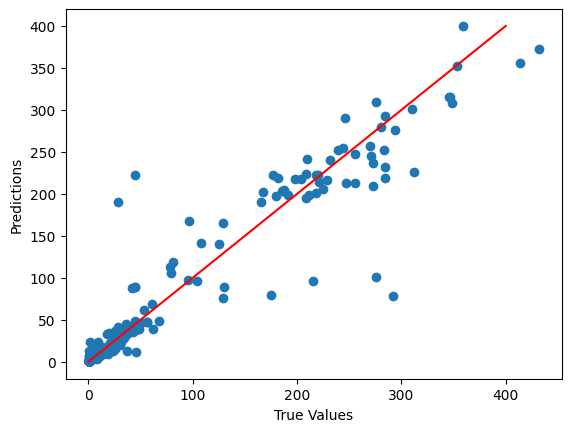

In [28]:
# 画图
# 用随机森林模型对测试集进行预测
y_pred = rf.predict(X_test)
# 将真实值为x轴，预测值为y轴
plt.scatter(y_test, y_pred)
# 绘制一条y=x的直线，作为参考
plt.plot([0, 400], [0, 400], 'r')
# 设置x轴和y轴的标签
plt.xlabel('True Values')
plt.ylabel('Predictions')
# 显示图像
plt.show()

In [29]:
# 建立GBDT模型
gbdt = GradientBoostingRegressor(n_estimators=100, max_depth=10, random_state=42)

# 训练模型
gbdt.fit(X_train, y_train)

# 评估GBDT模型
evaluate_model(gbdt, X_test, y_test)

MSE: 0.0891
R^2: 0.9210


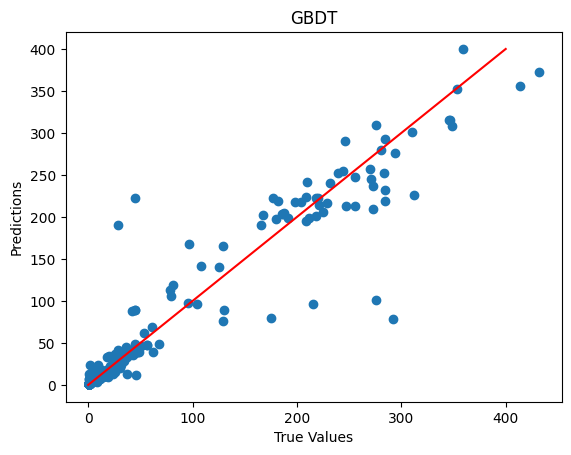

In [30]:
# 画图
# 用GBDT模型对测试集进行预测
y_pred = rf.predict(X_test)
# 将真实值为x轴，预测值为y轴
plt.scatter(y_test, y_pred)
# 绘制一条y=x的直线，作为参考
plt.plot([0, 400], [0, 400], 'r')
# 设置x轴和y轴的标签
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('GBDT')
# 显示图像
plt.show()

In [31]:
# 建立LSTM模型
X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
y_train_lstm = y_train.values.reshape((y_train.shape[0], 1))
y_test_lstm = y_test.values.reshape((y_test.shape[0], 1))
batch_size = 32 # 批次大小
n_steps = X_train_lstm.shape[0] // batch_size # 步长
X_train_lstm = X_train_lstm[:n_steps * batch_size] # 裁剪
y_train_lstm = y_train_lstm[:n_steps * batch_size] # 裁剪

lstm = Sequential() 
lstm.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))) # 添加一个LSTM层，输出维度为64
lstm.add(Dense(1)) # 添加一个全连接层，输出维度为1
lstm.add(Dropout(0.2))
# 编译模型，损失函数为均方误差，优化器为adam
lstm.compile(loss='mse', optimizer='adam',metrics=['accuracy']) 

# 实验发现LSTM模型的效果不佳，过拟合且r方为负
lstm.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=batch_size) # 用训练集拟合模型，迭代次数为10，批次大小为32
print('LSTM:')
evaluate_model(lstm, X_test_lstm, y_test_lstm) # 评估模型

Epoch 1/10
154357/154357 [==============================] - 147s 945us/step - loss: 1.2019 - accuracy: 0.7997
Epoch 2/10
154357/154357 [==============================] - 146s 947us/step - loss: 1.2004 - accuracy: 0.7996
Epoch 3/10
154357/154357 [==============================] - 137s 888us/step - loss: 1.1939 - accuracy: 0.7998
Epoch 4/10
154357/154357 [==============================] - 138s 896us/step - loss: 1.1969 - accuracy: 0.7998
Epoch 5/10
154357/154357 [==============================] - 143s 925us/step - loss: 1.1935 - accuracy: 0.7999
Epoch 6/10
154357/154357 [==============================] - 142s 921us/step - loss: 1.1913 - accuracy: 0.7996
Epoch 7/10
154357/154357 [==============================] - 143s 927us/step - loss: 1.1878 - accuracy: 0.7999
Epoch 8/10
154357/154357 [==============================] - 154s 996us/step - loss: 1.1856 - accuracy: 0.7994
Epoch 9/10
154357/154357 [==============================] - 143s 927us/step - loss: 1.1871 - accuracy: 0.7999
Epoch 10/1

In [32]:
# 随机森林效果最优，进行调参
from sklearn.model_selection import GridSearchCV

# 定义需要调整的参数范围，如树的数量、树的深度、特征选择等
param_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": [5, 10 ,15],
    "max_features": ["auto", "sqrt", "log2"]
}

# 初始化随机森林模型
rf = RandomForestRegressor(random_state=42)

# 分步调参
for param in param_grid:
    # 建立网格搜索对象，用于寻找最优参数值，并用5折交叉验证来评估性能 
    grid_search = GridSearchCV(rf, param_grid={param: param_grid[param]},
                               scoring="neg_mean_squared_error",
                               cv=5,
                               verbose=1,
                               n_jobs=-1)

    # 用训练集来进行网格搜索，并得到最优参数值和最优分数 
    grid_search.fit(X_train,y_train)
    best_value = grid_search.best_params_[param]
    best_score = grid_search.best_score_

    print(f"Best value for {param}: {best_value}")
    print(f"Best score: {best_score:.2f}")

    # 更新随机森林模型的参数
    rf.set_params(**{param: best_value})


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best value for n_estimators: 100
Best score: -0.07
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best value for max_depth: 15
Best score: -0.07
Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\Users\13801\anaconda3\envs\Pytorch\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best value for max_features: auto
Best score: -0.07


In [33]:
print(rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 15, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [34]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('New MSE:',mse)


New MSE: 0.07161974526200202


In [35]:
rf.fit(X_train, y_train)
importances = rf.feature_importances_

c:\Users\13801\anaconda3\envs\Pytorch\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [36]:
importances

array([0.02509099, 0.02635168, 0.16904717, 0.35107236, 0.20688174,
       0.22155607])